In [83]:
import tifffile
import numpy as np
import pandas as pd
import xs3d
import matplotlib.pyplot as plt
import importlib

importlib.reload(xs3d)

<module 'xs3d' from '/home/wanqing.yu/AC_Project/packages/cross-section/xs3d/__init__.py'>

In [98]:
# image file path
img_file = "/ACdata/Users/wanqing/exaSPIM/forOlga/Result of tile_x_0002_y_0001_z_0000_ch_488_mip2-8bit-zcut.tif"

# skeleton file path
sk_file = r'/ACdata/Users/wanqing/exaSPIM/exaSPIM_H17.24.006_2023-09-22_14-52-45/exaSPIM/mip2/x2y1z0/skeleton/skeletons_10/0002.swc'

In [85]:
# get the tiff info without loading the real data
with tifffile.TiffFile(img_file) as tif:
    img_shape = tif.pages[0].shape
    img_dtype = tif.pages[0].dtype
    
img_shape


(2688, 3584)

In [99]:
# read the sk file
sk = pd.read_csv(sk_file, sep=' ', header=None, comment='#', names=['id', 'type', 'x', 'y', 'z', 'radius', 'parent'])
sk


,id,type,x,y,z,radius,parent
0,1,2,1743.850,1924.85,246.000,3.2480,-1
1,2,2,1736.180,1924.00,249.000,6.4960,1
2,3,2,1727.880,1923.00,252.118,6.4960,2
3,4,2,1720.450,1921.45,255.000,6.4960,3
4,5,2,1713.200,1920.80,257.802,6.4960,4
...,...,...,...,...,...,...,...
144,145,2,900.347,2617.65,337.000,7.2627,144
145,146,2,898.058,2624.94,334.058,6.4960,145
146,147,2,894.571,2632.43,331.000,6.4960,146
147,148,2,891.000,2639.80,328.000,6.4960,147


In [87]:
resolution = [4, 2.961,2.962]
# slices = xs3d.slice_path(
# 	img, 
# 	sk_xyz[:10], 
# 	resolution, 
# 	smoothing=1,
# )

# slices = xs3d.slice_path_cutout(
# 	img, 
# 	sk_xyz[:20], 
# 	resolution, 
# 	smoothing=5,
# )

In [22]:
# slices

[array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0

In [12]:
# import simplejpeg
# for i, img in enumerate(slices):
# 	jpg = simplejpeg.encode_jpeg(
# 		np.ascontiguousarray(img[..., np.newaxis]), 
# 		colorspace="GRAY",
# 		quality=80,
# 	)
# 	with open(f"slices_p/{i}.jpg", "wb") as f:
# 		f.write(jpg)

In [5]:
# can resample the skeleton to different resolution
# but now just go with the current resolution


In [100]:
import navis

skeleton = navis.read_swc(sk_file, include_subdirs=True)
skeleton.nodes




,node_id,label,x,y,z,radius,parent_id,type
0,1,2,1743.849976,1924.849976,246.000000,3.2480,-1,root
1,2,2,1736.180054,1924.000000,249.000000,6.4960,1,slab
2,3,2,1727.880005,1923.000000,252.117996,6.4960,2,slab
3,4,2,1720.449951,1921.449951,255.000000,6.4960,3,slab
4,5,2,1713.199951,1920.800049,257.802002,6.4960,4,slab
...,...,...,...,...,...,...,...,...
144,145,2,900.346985,2617.649902,337.000000,7.2627,144,slab
145,146,2,898.057983,2624.939941,334.058014,6.4960,145,slab
146,147,2,894.570984,2632.429932,331.000000,6.4960,146,slab
147,148,2,891.000000,2639.800049,328.000000,6.4960,147,slab


In [101]:
skeleton_smoothed = navis.smooth_skeleton(skeleton, window=10, to_smooth=['x', 'y', 'z'])
skeleton_smoothed.nodes

Smoothing:   0%|          | 0/1 [00:00<?, ?it/s]

/home/wanqing.yu/anaconda3/envs/xs3d_test/lib/python3.11/site-packages/navis/morpho/manipulation.py:1622: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 889.          890.          891.5236613   893.15724182  894.59519043
  895.82932536  897.17885045  898.53149414  899.94388156  901.24949341
  903.75839233  906.25839233  908.67769165  910.87189331  912.92859497
  914.92859497  916.80099487  918.71349487  920.58919678  922.38919678
  924.28029785  926.18029785  928.65150146  931.36500244  934.37360229
  937.57360229  940.87360229  944.16110229  947.36110229  950.715802
  954.12600098  957.72600098  960.77839966  963.76489868  966.82279663
  970.02279663  973.38509521  976.78509521  980.40969238  984.13399048
  988.1237915   992.0237915   995.9237915   999.8237915  1003.76589355
 1007.57189941 1011.40960083 1015.30960083 1019.2000061  1023.20900879
 1027.10300293 1031.11900635 1035.31000977 1039.52401123

,node_id,label,x,y,z,radius,parent_id,type
0,1,2,1710.889990,1922.309998,258.361000,3.2480,-1,root
1,2,2,1703.431995,1922.225000,261.061000,6.4960,1,slab
2,3,2,1695.906995,1922.325000,263.761000,6.4960,2,slab
3,4,2,1688.335999,1922.625000,266.349200,6.4960,3,slab
4,5,2,1680.643005,1923.180005,268.897400,6.4960,4,slab
...,...,...,...,...,...,...,...,...
144,145,2,894.595190,2632.611963,331.211603,7.2627,144,slab
145,146,2,893.157242,2636.352478,329.764503,6.4960,145,slab
146,147,2,891.523661,2640.156657,328.333333,6.4960,146,slab
147,148,2,890.000000,2644.020020,327.000000,6.4960,147,slab


In [102]:
skeleton_rs = skeleton_smoothed.resample(1)
skeleton_rs.nodes

,node_id,parent_id,x,y,z,radius,type
0,149,150,889.000000,2648.239990,326.000000,6.496000,end
1,150,151,889.224877,2647.291016,326.224877,6.496000,slab
2,151,152,889.449754,2646.342041,326.449754,6.496000,slab
3,152,153,889.674631,2645.393067,326.674631,6.496000,slab
4,153,154,889.899508,2644.444092,326.899508,6.496000,slab
...,...,...,...,...,...,...,...
1260,1409,1410,1707.125913,1922.267099,259.723700,4.887277,slab
1261,1410,1411,1708.066932,1922.277824,259.383025,4.477458,slab
1262,1411,1412,1709.007952,1922.288548,259.042350,4.067638,slab
1263,1412,1,1709.948971,1922.299273,258.701675,3.657819,slab


In [103]:
fig = skeleton_rs.plot3d(backend='plotly', connectors=False)

In [104]:
skel_dp = navis.make_dotprops(skeleton_rs, k=30)
skel_dp

,
type,navis.Dotprops
name,0002
k,30
units,1 dimensionless
n_points,1265


In [105]:
skel_dp.vect

array([[-0.32574883,  0.89431405, -0.30674107],
       [-0.32574883,  0.89431405, -0.30674107],
       [-0.32574883,  0.89431405, -0.30674107],
       ...,
       [-0.94329849,  0.0215705 ,  0.33124413],
       [-0.94329849,  0.0215705 ,  0.33124413],
       [-0.94329849,  0.0215705 ,  0.33124413]])

In [17]:
skeleton_rs.nodes.loc[1]

node_id              148
parent_id            149
x            1956.788422
y             769.568387
z             333.761495
radius            4.5934
type                slab
Name: 1, dtype: object

In [106]:
normal = skel_dp.vect[:-1]
normal_next = skel_dp.vect[1:]
parallel = np.cross(normal, normal_next)
normal, parallel

(array([[-0.32574883,  0.89431405, -0.30674107],
        [-0.32574883,  0.89431405, -0.30674107],
        [-0.32574883,  0.89431405, -0.30674107],
        ...,
        [-0.94329849,  0.0215705 ,  0.33124413],
        [-0.94329849,  0.0215705 ,  0.33124413],
        [-0.94329849,  0.0215705 ,  0.33124413]]),
 array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 2.22044605e-16,  2.77555756e-17, -2.22044605e-16],
        ...,
        [ 0.00000000e+00,  5.55111512e-17, -3.46944695e-18],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]))

In [47]:
origins = np.array([[node[2], node[3], node[4]] for node in skeleton_rs.nodes.values])
origins = origins[:-1]

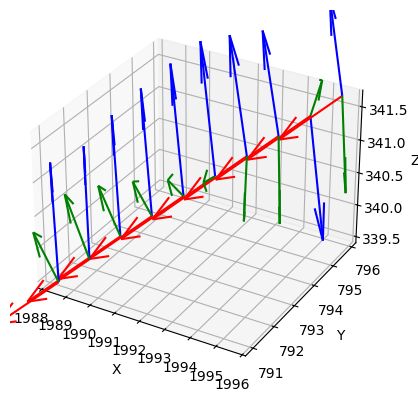

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

origins = np.array([[node[2], node[3], node[4]] for node in skeleton_rs.nodes.values])
origins = origins[40:50]
vectors = normal[40:50]
basis1 = parallel[40:50]
basis2 = np.cross(normal[40:50], basis1)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot an arrow for each node-vector pair
for origin, vec in zip(origins, vectors):
    ax.quiver(*origin, *vec, color = 'r', length=2, normalize=True)
for origin, vec in zip(origins, basis1):
    ax.quiver(*origin, *vec, color = 'g', length=2, normalize=True)
for origin, vec in zip(origins, basis2):
    ax.quiver(*origin, *vec, color = 'b', length=2, normalize=True)

# Labels for axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [74]:
normal[40:50]

array([[-0.804347  , -0.5335809 , -0.26137584],
       [-0.80337981, -0.53437753, -0.26271948],
       [-0.80294814, -0.53477577, -0.26322834],
       [-0.80256391, -0.53508509, -0.26377095],
       [-0.8022354 , -0.53530402, -0.26432548],
       [-0.80197094, -0.53543109, -0.26487009],
       [-0.80177884, -0.53546484, -0.26538293],
       [-0.80173086, -0.53530813, -0.26584362],
       [-0.80175255, -0.53496136, -0.2664755 ],
       [-0.80175255, -0.53496136, -0.2664755 ]])

In [72]:
import plotly.graph_objects as go
import numpy as np


# Function to create quiver plot data
def quiver_data(origins, vectors, color):
    x, y, z = origins.T  # Transpose to get arrays of x, y, z coordinates
    u, v, w = vectors.T  # Transpose to get arrays of vector components
    return go.Cone(x=x, y=y, z=z, u=u, v=v, w=w, colorscale=[[0, color], [1, color]], showscale=False)

# Create figure
fig = go.Figure()

# Add vectors to the plot
# fig.add_trace(quiver_data(origins, vectors, 'red'))
fig.add_trace(quiver_data(origins, basis1, 'green'))
fig.add_trace(quiver_data(origins, basis2, 'blue'))

# Update layout for a better view
fig.update_layout(scene=dict(
                    xaxis_title='X',
                    yaxis_title='Y',
                    zaxis_title='Z',
                    aspectratio=dict(x=1, y=1, z=1),
                    camera_eye=dict(x=1.2, y=1.2, z=1.2)))

# Show the plot
fig.show()

In [ ]:
normal[48],normal_next

In [76]:
np.cross(normal[48], normal_next[48])

array([-2.77555756e-17,  5.55111512e-17,  0.00000000e+00])

In [79]:
np.all(parallel[48] < 10-6)

True

In [107]:
from tifffile import TiffFile, imsave
import numpy as np

width = 200
img_proj_pp = []
img_proj_vv = []

normal = skel_dp.vect[16]
normal_next = skel_dp.vect[16+1]
normal = [normal[2],normal[1],normal[0]]
normal_next = [normal_next[2],normal_next[1],normal_next[0]]

parallel_pre = np.cross(normal, normal_next)

# Open the image
with TiffFile(img_file) as tif:
    # Convert the image to a 3D numpy array
    img = tif.asarray()

    # Get the first node in the skeleton
    for i, node in skeleton_rs.nodes.loc[16:(len(skeleton_rs.nodes)-18)].iterrows():
        # Use the node's position as the center point
        center_x, center_y, center_z = node['x'], node['y'], node['z']

        # Calculate the start and end points of the cutout
        start_x, end_x = center_x - width // 2, center_x + width // 2
        start_y, end_y = center_y - width // 2, center_y + width // 2
        start_z, end_z = center_z - width // 2, center_z + width // 2

        # Make sure the start and end points are within the image boundaries
        start_x, end_x = int(max(0, start_x)), int(min(img.shape[2], end_x))
        start_y, end_y = int(max(0, start_y)), int(min(img.shape[1], end_y))
        start_z, end_z = int(max(0, start_z)), int(min(img.shape[0], end_z))

        # Extract the cutout
        cutout = img[start_z:end_z, start_y:end_y, start_x:end_x]


        # Subtract the parent node vector from the current node vector
        normal = skel_dp.vect[i]
        normal_next = skel_dp.vect[i+1]
        normal = [normal[2],normal[1],normal[0]]
        normal_next = [normal_next[2],normal_next[1],normal_next[0]]

        parallel = np.cross(normal, normal_next)
        # parallel = parallel / np.linalg.norm(parallel)

        # assuming the first parallel vector is not 0 
        # need to fix this later
        if np.all(parallel < 10-8):
            parallel = parallel_pre 

        # img_proj_v = xs3d.slice(cutout, np.array([width/2+1,width/2+1,width/2+1]), normal, anisotropy=(4, 2.961,2.962), standardize_basis=False)
        # img_proj_p = xs3d.slice(cutout, np.array([width/2+1,width/2+1,width/2+1]), parallel, anisotropy=(4, 2.961,2.962), standardize_basis=False)
        img_proj_v = xs3d.slice_path_single(cutout, np.array([width/2+1,width/2+1,width/2+1]), np.cross(normal,parallel), parallel, anisotropy=(4, 2.961,2.962))
        img_proj_p = xs3d.slice_path_single(cutout, np.array([width/2+1,width/2+1,width/2+1]), normal, parallel, anisotropy=(4, 2.961,2.962))

        parallel_pre = parallel
        
        img_proj_pp.append(img_proj_p)
        img_proj_vv.append(img_proj_v)

    # save the cutout image volume as tif
    # imsave('cutout.tif', cutout)




In [11]:
# from tifffile import TiffFile, imsave
# import numpy as np

# width = 400
# img_proj_pp = []
# img_proj_vv = []

# # Open the image
# with TiffFile(img_file) as tif:
#     # Convert the image to a 3D numpy array
#     img = tif.asarray()

#     # Get the first node in the skeleton
#     for i, node in sk.loc[1:(len(sk)-2)].iterrows():
#         # Use the node's position as the center point
#         center_x, center_y, center_z = node['x'], node['y'], node['z']

#         # Calculate the start and end points of the cutout
#         start_x, end_x = center_x - width // 2, center_x + width // 2
#         start_y, end_y = center_y - width // 2, center_y + width // 2
#         start_z, end_z = center_z - width // 2, center_z + width // 2

#         # Make sure the start and end points are within the image boundaries
#         start_x, end_x = int(max(0, start_x)), int(min(img.shape[2], end_x))
#         start_y, end_y = int(max(0, start_y)), int(min(img.shape[1], end_y))
#         start_z, end_z = int(max(0, start_z)), int(min(img.shape[0], end_z))

#         # Extract the cutout
#         cutout = img[start_z:end_z, start_y:end_y, start_x:end_x]

#         # Get the parent node
#         pre_node = sk[sk['id'] == node['parent']]
#         next_node = sk[sk['parent'] == node['id']]


#         # Subtract the parent node vector from the current node vector
#         v = np.array([node.z - next_node.z, node.y - next_node.y, node.x - next_node.x])
#         v = v.flatten()
#         u = np.array([pre_node.z - node.z, pre_node.y - node.y, pre_node.x - node.x])
#         u = u.flatten()
#         normal = v / np.linalg.norm(v)
        
#         parallel = np.cross(u, v)
#         # assuming the first parallel vector is not 0 
#         # need to fix this later
#         if np.all(parallel == 0):
#             parallel = parallel_pre 

#         # img_proj_v = xs3d.slice(cutout, np.array([width/2+1,width/2+1,width/2+1]), normal, anisotropy=(4, 2.961,2.962), standardize_basis=False)
#         # img_proj_p = xs3d.slice(cutout, np.array([width/2+1,width/2+1,width/2+1]), parallel, anisotropy=(4, 2.961,2.962), standardize_basis=False)
#         img_proj_v = xs3d.slice_path_single(cutout, np.array([width/2+1,width/2+1,width/2+1]), np.cross(normal,parallel), parallel, anisotropy=(4, 2.961,2.962))
#         img_proj_p = xs3d.slice_path_single(cutout, np.array([width/2+1,width/2+1,width/2+1]), parallel, normal, anisotropy=(4, 2.961,2.962))

#         parallel_pre = parallel
        
#         img_proj_pp.append(img_proj_p)
#         img_proj_vv.append(img_proj_v)

#     # save the cutout image volume as tif
#     # imsave('cutout.tif', cutout)




In [108]:
# Determine the maximum dimensions
max_height = max(img.shape[0] for img in img_proj_pp)
max_width = max(img.shape[1] for img in img_proj_pp)

# Create a new list to hold the padded images
img_proj_pp_padded = []

# Pad each image
for img in img_proj_pp:
    # Determine the padding amounts
    pad_height = max_height - img.shape[0]
    pad_width = max_width - img.shape[1]
    
    # Split the padding amounts evenly between the top/bottom and left/right
    pad_height1, pad_height2 = pad_height // 2, pad_height - pad_height // 2
    pad_width1, pad_width2 = pad_width // 2, pad_width - pad_width // 2
    
    # Pad the image
    img_padded = np.pad(img, ((pad_height1, pad_height2), (pad_width1, pad_width2)))
    
    # Add the padded image to the list
    img_proj_pp_padded.append(img_padded)

# Convert the list back to a numpy array
img_proj_pp_padded = np.array(img_proj_pp_padded)

imsave('/home/wanqing.yu/AC_Project/ac_visualization/proofreading-demo/0002/img_proj_p_new_rs_smooth.tif', img_proj_pp_padded)

/tmp/ipykernel_251003/2804456275.py:27: DeprecationWarning:

<tifffile.imsave> is deprecated. Use tifffile.imwrite



In [109]:
# Determine the maximum dimensions
max_height = max(img.shape[0] for img in img_proj_vv)
max_width = max(img.shape[1] for img in img_proj_vv)

# Create a new list to hold the padded images
img_proj_vv_padded = []

# Pad each image
for img in img_proj_vv:
    # Determine the padding amounts
    pad_height = max_height - img.shape[0]
    pad_width = max_width - img.shape[1]
    
    # Split the padding amounts evenly between the top/bottom and left/right
    pad_height1, pad_height2 = pad_height // 2, pad_height - pad_height // 2
    pad_width1, pad_width2 = pad_width // 2, pad_width - pad_width // 2
    
    # Pad the image
    img_padded = np.pad(img, ((pad_height1, pad_height2), (pad_width1, pad_width2)))
    
    # Add the padded image to the list
    img_proj_vv_padded.append(img_padded)

# Convert the list back to a numpy array
img_proj_vv_padded = np.array(img_proj_vv_padded)

imsave('/home/wanqing.yu/AC_Project/ac_visualization/proofreading-demo/0002/img_proj_v_new_rs_smooth.tif', img_proj_vv_padded)

/tmp/ipykernel_251003/702268156.py:27: DeprecationWarning:

<tifffile.imsave> is deprecated. Use tifffile.imwrite



In [75]:
#  # save the cutout image volume as tif
# imsave('cutout.tif', cutout)

/tmp/ipykernel_2250885/2283751380.py:2: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  imsave('cutout.tif', cutout)


In [127]:
# cutout

array([[[24, 23, 25, ..., 29, 28, 30],
        [26, 24, 24, ..., 32, 28, 30],
        [25, 25, 26, ..., 33, 32, 32],
        ...,
        [37, 36, 36, ..., 28, 35, 28],
        [31, 35, 33, ..., 28, 30, 28],
        [25, 26, 28, ..., 25, 26, 25]],

       [[25, 24, 26, ..., 32, 31, 31],
        [24, 22, 24, ..., 38, 32, 31],
        [23, 24, 24, ..., 40, 42, 40],
        ...,
        [42, 36, 33, ..., 29, 31, 25],
        [30, 31, 29, ..., 28, 30, 25],
        [21, 22, 25, ..., 26, 25, 24]],

       [[25, 25, 26, ..., 36, 31, 30],
        [24, 24, 25, ..., 50, 37, 32],
        [23, 23, 24, ..., 54, 54, 45],
        ...,
        [36, 30, 28, ..., 27, 26, 23],
        [23, 24, 24, ..., 27, 27, 24],
        [17, 18, 20, ..., 26, 25, 23]],

       ...,

       [[29, 28, 27, ..., 32, 32, 33],
        [30, 29, 28, ..., 31, 32, 32],
        [30, 30, 29, ..., 30, 31, 31],
        ...,
        [36, 35, 34, ..., 34, 34, 34],
        [35, 35, 35, ..., 36, 36, 34],
        [36, 34, 34, ..., 37, 36

/home/wanqing.yu/anaconda3/envs/EM/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/wanqing.yu/anaconda3/envs/EM/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/wanqing.yu/anaconda3/envs/EM/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/wanqing.yu/anaconda3/envs/EM/lib/python3.11/site-packages/I

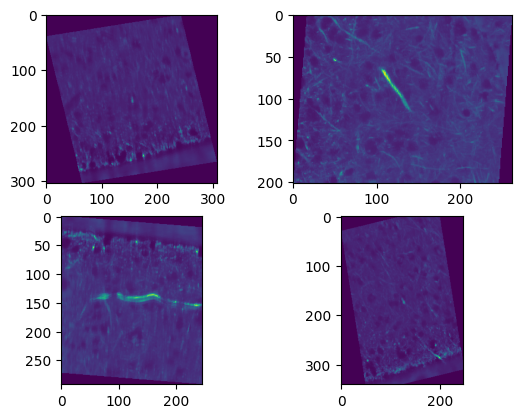

In [144]:
# from tifffile import TiffFile, imsave
# import numpy as np

# width = 200
# img_proj_pp = []
# img_proj_vv = []
# img_proj_pp2 = []
# img_proj_pp3 = []

# # Open the image
# with TiffFile(img_file) as tif:
#     # Convert the image to a 3D numpy array
#     img = tif.asarray()

#     # Get the first node in the skeleton
#     # for i, node in sk.loc[0:(len(sk)-2)].iterrows():
#     node = sk.loc[0]
#     # Use the node's position as the center point
#     center_x, center_y, center_z = node['x'], node['y'], node['z']

#     # Calculate the start and end points of the cutout
#     start_x, end_x = center_x - width // 2, center_x + width // 2
#     start_y, end_y = center_y - width // 2, center_y + width // 2
#     start_z, end_z = center_z - width // 2, center_z + width // 2

#     # Make sure the start and end points are within the image boundaries
#     start_x, end_x = int(max(0, start_x)), int(min(img.shape[2], end_x))
#     start_y, end_y = int(max(0, start_y)), int(min(img.shape[1], end_y))
#     start_z, end_z = int(max(0, start_z)), int(min(img.shape[0], end_z))

#     # Extract the cutout
#     cutout = img[start_z:end_z, start_y:end_y, start_x:end_x]

#     # Get the parent node
#     next_node = sk[sk['parent'] == node['id']]

#     # # Create a 3D vector from the current node's coordinates
#     # node_vector = np.array([node.x, node.y, node.z])

#     # # Create a 3D vector from the parent node's coordinates
#     # pre_node_vector = np.array([pre_node.x, pre_node.y, pre_node.z])

#     # Subtract the parent node vector from the current node vector
#     vector = np.array([node.z - next_node.z, node.y - next_node.y, node.x - next_node.x])
#     vector = vector.flatten()
#     normal = vector / np.linalg.norm(vector)
#     #Calculate the projection image
#     img_proj_v = xs3d.slice(cutout, np.array([width/2+1,width/2+1,width/2+1]), normal, anisotropy=(4, 2.961,2.962))

#     # rotate the normal vector 90 degrees
#     normal_rot = np.array([normal[1], -normal[0], normal[2]])
#     #Calculate the projection image
#     img_proj_p = xs3d.slice(cutout, np.array([width/2+1,width/2+1,width/2+1]), normal_rot, anisotropy=(4, 2.961,2.962))

#     # rotate the normal vector 90 degrees along another axis
#     normal_rot_axis = np.array([normal[0], normal[2], -normal[1]])
#     img_proj_p2 = xs3d.slice(cutout, np.array([width/2+1,width/2+1,width/2+1]), normal_rot_axis, anisotropy=(4, 2.961,2.962))

#     # rotate the normal vector 90 degrees along another axis
#     normal_rot_axis3 = np.array([-normal[2], normal[1], normal[0]])
#     img_proj_p3 = xs3d.slice(cutout, np.array([width/2+1,width/2+1,width/2+1]), normal_rot_axis3, anisotropy=(4, 2.961,2.962))

#     img_proj_pp.append(img_proj_p)
#     img_proj_vv.append(img_proj_v)
#     img_proj_pp2.append(img_proj_p2)
#     img_proj_pp3.append(img_proj_p3)

#     # plot all three projection image
#     plt.figure()
#     plt.subplot(221)
#     plt.imshow(img_proj_v)
#     plt.subplot(222)
#     plt.imshow(img_proj_p)
#     plt.subplot(223)
#     plt.imshow(img_proj_p2)
#     plt.subplot(224)
#     plt.imshow(img_proj_p3)
#     plt.show()

#     # save the cutout image volume as tif
#     # imsave('cutout.tif', cutout)


